In [1]:
# Add base directory for forestfire project to path to allow use of utils
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import glob
import os
import scipy
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from IPython import display
import tensorflow as tf
from tensorflow.keras.layers import*
from tensorflow.keras.applications import*
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from utils.tensorflow_utils import LRFinder, OneCycleScheduler
from tensorflow.keras.utils import plot_model

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
patch_df = pd.read_parquet("/root/patches/patch_df.parquet").dropna()

patch_df["label"] = (patch_df["smoky_pixel_pct"] >= 0.05).astype(int).astype(str)

unique_stems = patch_df[["original_image_stem"]].drop_duplicates()
train_original_image_stems, valid_original_image_stems, test_original_image_stems = np.split(unique_stems.sample(frac=1),
                                                                                             [int(.6*len(unique_stems)), int(.8*len(unique_stems))])

train_image_df = patch_df.merge(train_original_image_stems, on=["original_image_stem"])
valid_image_df = patch_df.merge(valid_original_image_stems, on=["original_image_stem"])
test_image_df = patch_df.merge(test_original_image_stems, on=["original_image_stem"])

In [6]:
train_image_df

,original_image_stem,full_image_smoky_pixels,patch_image,patch_mask,smoky_pixel_pct,label
0,4944,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
1,4944,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
2,4944,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
3,4944,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
4,4944,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
...,...,...,...,...,...,...
134129,8068,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
134130,8068,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
134131,8068,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0
134132,8068,0.0,/root/patches/images/256x256_256x256_threshold...,/root/patches/masks/256x256_256x256_threshold_...,0.0,0


In [7]:
train_image_df["label"].value_counts()

0    117553
1     16581
Name: label, dtype: int64

In [8]:
IMAGE_SIZE = (128, 128)
IMG_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
BATCH_SIZE = 256

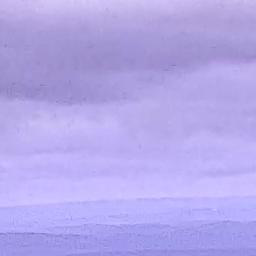

In [9]:
# Display a sample image with no smoke
Image.open(str(train_image_df[train_image_df["label"] == "0"]["patch_image"].sample(n=1).tolist()[0]))

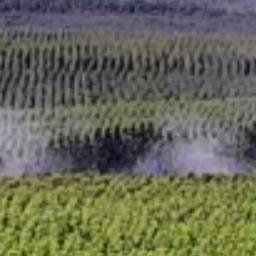

In [10]:
# Display a sample image with smoke
Image.open(str(train_image_df[train_image_df["label"] == "1"]["patch_image"].sample(n=1).tolist()[0]))

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_image_df,
    directory="/",
    x_col="patch_image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

test_generator=datagen.flow_from_dataframe(
    dataframe=test_image_df,
    directory="/",
    x_col="patch_image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid_image_df,
    directory="/",
    x_col="patch_image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=IMAGE_SIZE
)

Found 134134 validated image filenames belonging to 2 classes.
Found 44298 validated image filenames belonging to 2 classes.
Found 44298 validated image filenames belonging to 2 classes.


In [12]:
def resnet_class_model():
    res_net = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    
    # Freeze RESNET Layers, except BatchNormalization
    res_net.trainable = False

#     for layer in res_net.layers:
#         if str(type(layer)) == "<class 'tensorflow.python.keras.layers.normalization.BatchNormalization'>":
#             layer.trainable = True

    x = res_net.output
    global_average_1 = GlobalAveragePooling2D()(x)
#     global_max_1 = GlobalMaxPooling2D()(x)
#     concat_1 = Concatenate()([global_average_1, global_max_1])
#     dropout_1 = Dropout(0.25)(concat_1)
#     dense_1 = Dense(512, activation='relu')(dropout_1)
#     batch_norm_1 = BatchNormalization()(dense_1)
#     dropout_2 = Dropout(0.5)(batch_norm_1)
    prediction_layer = Dense(1, activation='sigmoid')(global_average_1)
    return Model(inputs=res_net.input, outputs=prediction_layer)

In [ ]:
# plot_model(model, show_shapes=True)

In [ ]:
model = resnet_class_model()
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

lr_finder = LRFinder(max_steps=100)

history = model.fit_generator(epochs=3,
                              generator=train_generator,
                              steps_per_epoch=len(train_image_df) // BATCH_SIZE,
                              callbacks=[lr_finder], max_queue_size=16, workers=4)

lr_finder.plot()

In [ ]:
lr = 4e-3
initial_epochs = 5
steps = len(train_generator) * initial_epochs

model = resnet_class_model()

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

one_cycle = OneCycleScheduler(lr, steps)

history = model.fit_generator(epochs=initial_epochs,
                              generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              callbacks=[],
                              max_queue_size=32, workers=4)

In [ ]:
one_cycle.plot()

In [ ]:
model.save("initial_model")

In [ ]:
lr_finder = LRFinder(max_steps=100)

history = model.fit_generator(epochs=3,
                              generator=train_generator,
                              steps_per_epoch=len(train_image_df) // BATCH_SIZE,
                              callbacks=[lr_finder], max_queue_size=16, workers=4)

lr_finder.plot()

In [ ]:
# Set the model to trainable, and train for another couple of epochs with one-cycle
model = tf.keras.models.load_model('initial_model')
model.trainable = True

lr = 1e-3
fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs
steps = len(train_generator) * fine_tune_epochs

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(epochs=total_epochs,
                              initial_epoch = initial_epochs,
                              generator=train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator),
                              validation_steps=len(valid_generator),
                              callbacks=[early_stop],
                              max_queue_size=50, workers=6)

In [ ]:
res_net = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [ ]:
res_net.summary()

In [ ]:
model.summary()